In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import sklearn
import seaborn as sn
from datetime import date
from pprint import pprint
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
label_encoder = LabelEncoder()
onehot_encoder = OneHotEncoder()

In [3]:
df = pd.read_csv('training_data_cleaned.csv')

# Data Cleanup

Drop unnamed since it is just a row count.

Drop the `year` column since it is redundant and already included in the `dt` column.

Drop the `dim_carrier_type` column since it is redundant and already included in the `id_carrier_number` column.

Convert the `dt` column to Python `datetime.date` objects

In [4]:
df.drop(columns=['Unnamed: 0', 'year', 'dim_carrier_type', 'date', 'recent_date'], inplace=True)
df.dt = [date.fromisoformat(d) for d in df.dt]

# Data Inspection

In [5]:
df.head()

,dt,weekday,id_driver,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,...,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
0,2021-01-20,3,30222,U0117613,Rosas Transport,Santa Fe Springs,CA,"[""poweronly""]",1.0,not specified,...,2021-02-17,2021-01-20,4,1,253,254,0,3,3,257
1,2020-03-09,1,4524,C0090405,Daylight Transport,Long Beach,CA,"[""dryvan""]",6.0,not specified,...,2021-02-15,2020-03-09,6,0,0,0,2671,0,2671,2671
2,2020-02-14,5,31164,C0097099,First Class Transport #8,Hawthorne,CA,"[""poweronly"", ""dryvan""]",3.0,yes,...,2020-12-18,2020-02-14,1,29,82,111,30,19,49,160
3,2019-06-10,1,8859,U0097935,DTELLIS TRUCKING,Long Beach,CA,"[""dryvan""]",1.0,not specified,...,2020-02-16,2019-06-10,1,25,6,31,0,1,1,32
4,2019-12-03,2,18870,U0106560,Z&N Transport,Los Angeles,CA,"[""dryvan""]",1.0,not specified,...,2020-02-18,2019-12-03,4,1,233,234,0,9,9,243


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83414 entries, 0 to 83413
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   dt                        83414 non-null  object 
 1   weekday                   83414 non-null  int64  
 2   id_driver                 83414 non-null  int64  
 3   id_carrier_number         83414 non-null  object 
 4   dim_carrier_company_name  83367 non-null  object 
 5   home_base_city            83369 non-null  object 
 6   home_base_state           83369 non-null  object 
 7   carrier_trucks            83414 non-null  object 
 8   num_trucks                83344 non-null  float64
 9   interested_in_drayage     83414 non-null  object 
 10  port_qualified            83414 non-null  object 
 11  signup_source             83414 non-null  object 
 12  ts_signup                 83414 non-null  object 
 13  ts_first_approved         71142 non-null  object 
 14  days_s

In [7]:
df.describe()

,weekday,id_driver,num_trucks,days_signup_to_approval,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
count,83414.000000,83414.000000,83344.000000,71142.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000,83414.000000
mean,3.500060,18224.058060,22.579538,298.646201,2.075659,29.536241,71.511533,101.047774,148.027561,13.080166,161.107728,266.273371
std,1.687443,11667.851627,48.816676,390.377138,2.669705,88.308416,194.548817,214.587614,415.376825,42.274194,413.197837,448.353468
min,1.000000,20.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,7890.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,37.000000
50%,3.000000,16299.000000,4.000000,61.000000,1.000000,2.000000,0.000000,13.000000,15.000000,0.000000,37.000000,110.000000
75%,5.000000,28974.000000,14.000000,497.000000,2.000000,23.000000,18.000000,94.000000,110.000000,1.000000,135.000000,325.000000
max,7.000000,38096.000000,195.000000,1653.000000,129.000000,902.000000,1324.000000,1348.000000,4266.000000,371.000000,4266.000000,4266.000000


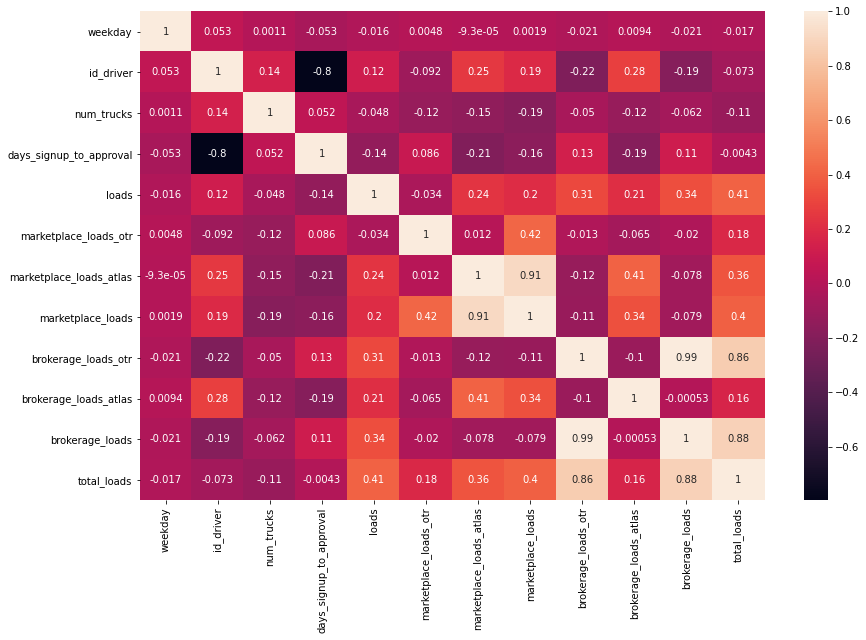

In [8]:
plt.figure(figsize=(14,9))
sn.heatmap(df.corr(), annot=True)
plt.show()

# Data Roll-Up - Create unique rows by aggregating by driver ID

In [9]:
categoricals = df.columns[df.dtypes == object]
numericals = df.columns[df.dtypes != object]
n_drivers = df.id_driver.nunique()
driver_ids = sorted(df.id_driver.unique())

## Aggregation Methodology

`id_driver`: Used as an index. All of the information will be rolled up into a single row for each driver.

In [10]:
drivers = pd.DataFrame()
drivers['id_driver'] = driver_ids
drivers.set_index('id_driver', inplace=True)

In [11]:
drivers.head()

""
id_driver
20
26
27
30
31


---

`dt`: three columns: earliest, latest, and longevity

In [12]:
drivers['dt_earliest'] = df.groupby('id_driver').dt.min()
drivers['dt_latest'] = df.groupby('id_driver').dt.max()
drivers['longevity'] = [t.days + 1 for t in drivers.dt_latest - drivers.dt_earliest]

In [13]:
drivers.head()

,dt_earliest,dt_latest,longevity
id_driver,,,
20,2015-10-23,2016-06-20,242
26,2015-10-29,2015-10-29,1
27,2015-10-18,2015-12-09,53
30,2018-10-30,2018-12-05,37
31,2016-02-28,2016-04-01,34


---

`weekday (mon, wed, etc)`: most frequent weekday

In [14]:
drivers['weekday'] = df.groupby('id_driver').weekday.agg(pd.Series.mode)

In [15]:
drivers.head()

,dt_earliest,dt_latest,longevity,weekday
id_driver,,,,
20,2015-10-23,2016-06-20,242,4
26,2015-10-29,2015-10-29,1,4
27,2015-10-18,2015-12-09,53,3
30,2018-10-30,2018-12-05,37,3
31,2016-02-28,2016-04-01,34,2


---

`dim_carrier_type`: Redundant, already included in `id_carrier_number`, which starts with a `U` if `Onwer Operator` and a `C` if `Fleet`

`id_carrier_number`: Encode a new boolean column (called `owner_operator`) that is 0 if `Fleet` or 1 if `Owner Operator`

In [16]:
self_owned = sorted(df.id_driver[df.id_carrier_number.str.slice(start=0, stop=1) == 'U'].unique())

In [17]:
drivers['self_owned'] = False
drivers['self_owned'] = label_encoder.fit_transform(drivers.index.isin(self_owned))

In [18]:
drivers.self_owned.value_counts()

0    4083
1    1205
Name: self_owned, dtype: int64

---



In [19]:
drivers['carrier_trucks'] = df.groupby('id_driver').carrier_trucks.agg(pd.Series.mode)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks
id_driver,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]"
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]"
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]"
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]"
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]"
...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]"
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]"
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]"


---



In [20]:
drivers['driver_home_base_state'] = df.groupby('id_driver').home_base_state.agg(pd.Series.mode)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks,driver_home_base_state
id_driver,,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]",CA
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]",CA
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]",CA
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]",CA
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]",[]
...,...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]",CA
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]",CA
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]",CA


In [21]:
driver_port_qualified = df.groupby('id_driver').port_qualified.agg(pd.Series.mode)
label_encoder.fit(['no', 'yes'])
drivers['port_qualified'] = label_encoder.transform(driver_port_qualified)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks,driver_home_base_state,port_qualified
id_driver,,,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]",CA,0
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]",CA,0
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]",CA,0
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]",CA,0
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]",[],0
...,...,...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]",CA,1
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]",CA,0
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]",CA,1


---

In [22]:
interested_in_drayage = df.groupby('id_driver').interested_in_drayage.agg(pd.Series.mode)
interested_in_dryage = interested_in_drayage == 'yes'
drivers['interested_in_dryage'] = label_encoder.fit_transform(interested_in_dryage)
drivers

,dt_earliest,dt_latest,longevity,weekday,self_owned,carrier_trucks,driver_home_base_state,port_qualified,interested_in_dryage
id_driver,,,,,,,,,
20,2015-10-23,2016-06-20,242,4,1,"[""dryvan""]",CA,0,0
26,2015-10-29,2015-10-29,1,4,1,"[""dryvan""]",CA,0,0
27,2015-10-18,2015-12-09,53,3,1,"[""dryvan""]",CA,0,0
30,2018-10-30,2018-12-05,37,3,1,"[""reefer""]",CA,0,0
31,2016-02-28,2016-04-01,34,2,1,"[""dryvan""]",[],0,0
...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,2021-02-11,1,4,0,"[""poweronly""]",CA,1,1
38039,2021-02-16,2021-02-16,1,2,0,"[""dryvan""]",CA,0,0
38060,2021-02-12,2021-02-13,2,"[5, 6]",0,"[""poweronly"", ""dryvan""]",CA,1,1


In [23]:
pd.get_dummies(df.signup_source)

,Mobile,Other
0,1,0
1,0,1
2,0,1
3,0,1
4,0,1
...,...,...
83409,0,1
83410,0,1
83411,0,1
83412,0,1


# Get the latest trip for each unique ID

In [24]:
driver_most_recent = df.groupby('id_driver').agg('max')

In [25]:
driver_most_recent

,dt,weekday,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,...,most_recent_load_date,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,7,U0000035,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,no,...,2016-06-20,2016-06-20,4,0,0,0,42,0,42,42
26,2015-10-29,4,U0000041,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,2015-10-29,2015-10-29,1,0,0,0,1,0,1,1
27,2015-12-09,7,U0000042,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,2015-12-09,2015-12-09,2,0,0,0,11,0,11,11
30,2018-12-05,3,U0000045,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,no,...,2018-12-05,2018-12-05,1,0,0,0,4,0,4,4
31,2016-04-01,7,U0000046,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,no,...,2016-04-01,2016-04-01,4,0,0,0,15,0,15,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,4,C0098303,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,yes,...,2021-02-11,2021-02-11,2,0,0,0,0,2,2,2
38039,2021-02-16,2,C0096844,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,no,...,2021-02-16,2021-02-16,1,1,0,1,0,0,0,1
38060,2021-02-13,6,C0094651,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,...,2021-02-13,2021-02-13,2,0,0,0,0,0,0,3


## Add boolean column for "self owned" or not

In [26]:
driver_most_recent['self_owned'] = False
driver_most_recent['self_owned'] = label_encoder.fit_transform(driver_most_recent.index.isin(self_owned))

In [27]:
driver_most_recent

,dt,weekday,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,...,load_day,loads,marketplace_loads_otr,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,self_owned
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,7,U0000035,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,no,...,2016-06-20,4,0,0,0,42,0,42,42,1
26,2015-10-29,4,U0000041,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,2015-10-29,1,0,0,0,1,0,1,1,1
27,2015-12-09,7,U0000042,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,2015-12-09,2,0,0,0,11,0,11,11,1
30,2018-12-05,3,U0000045,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,no,...,2018-12-05,1,0,0,0,4,0,4,4,1
31,2016-04-01,7,U0000046,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,no,...,2016-04-01,4,0,0,0,15,0,15,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,4,C0098303,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,yes,...,2021-02-11,2,0,0,0,0,2,2,2,0
38039,2021-02-16,2,C0096844,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,no,...,2021-02-16,1,1,0,1,0,0,0,1,0
38060,2021-02-13,6,C0094651,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,...,2021-02-13,2,0,0,0,0,0,0,3,0


## Add columns for mean, median, and standard deviation of dates

In [28]:
df['Date_int'] = pd.to_datetime(df['dt']).astype(int)
res = df.groupby('id_driver').agg(['mean', 'median', 'std'])
res.columns = ['_'.join(c) for c in res.columns.values]

res['Date_mean'] = pd.to_datetime(res['Date_int_mean'])
res['Date_median'] = pd.to_datetime(res['Date_int_median'])
res['Date_std'] = pd.to_timedelta(res['Date_int_std'])
res = res[['Date_mean', 'Date_median', 'Date_std']]

driver_most_recent['dt_mean'] = res['Date_mean']
driver_most_recent['dt_median'] = res['Date_median']
driver_most_recent['dt_std'] = res['Date_std']
# driver_most_recent.drop(columns=['Date_int'], inplace=True)

In [29]:
driver_most_recent.head()

,dt,weekday,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,...,marketplace_loads_atlas,marketplace_loads,brokerage_loads_otr,brokerage_loads_atlas,brokerage_loads,total_loads,self_owned,dt_mean,dt_median,dt_std
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,7,U0000035,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,no,...,0,0,42,0,42,42,1,2016-01-13 09:46:40.000000000,2015-12-29 00:00:00,60 days 03:42:24.874807908
26,2015-10-29,4,U0000041,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,0,0,1,0,1,1,1,2015-10-29 00:00:00.000000000,2015-10-29 00:00:00,NaT
27,2015-12-09,7,U0000042,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,...,0,0,11,0,11,11,1,2015-11-15 16:00:00.000000000,2015-11-23 00:00:00,18 days 16:21:25.202212076
30,2018-12-05,3,U0000045,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,no,...,0,0,4,0,4,4,1,2018-11-16 18:00:00.000000000,2018-11-16 12:00:00,19 days 22:32:52.091717299
31,2016-04-01,7,U0000046,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,no,...,0,0,15,0,15,15,1,2016-03-17 10:54:32.727272704,2016-03-15 00:00:00,12 days 00:16:21.353745482


## Add columns for mean, median, and standard deviation of weekday

In [68]:
driver_most_recent['weekday_mean'] = round(df.groupby('id_driver').weekday.agg(['mean'])).astype(int)
driver_most_recent['weekday_median'] = round(df.groupby('id_driver').weekday.agg(['median'])).astype(int)
driver_most_recent['weekday_std'] = round(df.groupby('id_driver').weekday.agg(['std']))
driver_most_recent.drop(columns=['weekday'], inplace=True)

In [75]:
driver_most_recent

,dt,id_carrier_number,dim_carrier_company_name,home_base_city,home_base_state,carrier_trucks,num_trucks,interested_in_drayage,port_qualified,signup_source,...,brokerage_loads_atlas,brokerage_loads,total_loads,self_owned,dt_mean,dt_median,dt_std,weekday_mean,weekday_median,weekday_std
id_driver,,,,,,,,,,,,,,,,,,,,,
20,2016-06-20,U0000035,Mega Fleet Corp,Pasadena,CA,"[""dryvan""]",1.0,not specified,no,Other,...,0,42,42,1,2016-01-13 09:46:40.000000000,2015-12-29 00:00:00,60 days 03:42:24.874807908,3,4,2.0
26,2015-10-29,U0000041,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,...,0,1,1,1,2015-10-29 00:00:00.000000000,2015-10-29 00:00:00,NaT,4,4,NaN
27,2015-12-09,U0000042,NaN,"Sierra Madre,",CA,"[""dryvan""]",1.0,not specified,no,Other,...,0,11,11,1,2015-11-15 16:00:00.000000000,2015-11-23 00:00:00,18 days 16:21:25.202212076,4,3,2.0
30,2018-12-05,U0000045,A & J Transport,Riverside,CA,"[""reefer""]",1.0,not specified,no,Other,...,0,4,4,1,2018-11-16 18:00:00.000000000,2018-11-16 12:00:00,19 days 22:32:52.091717299,2,2,1.0
31,2016-04-01,U0000046,lv transportation llc,NaN,NaN,"[""dryvan""]",1.0,not specified,no,Other,...,0,15,15,1,2016-03-17 10:54:32.727272704,2016-03-15 00:00:00,12 days 00:16:21.353745482,3,2,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37977,2021-02-11,C0098303,"DOLPHIN TRANS, INC. DBA DOLPHIN EXPRESS",Norwalk,CA,"[""poweronly""]",1.0,yes,yes,Other,...,2,2,2,0,2021-02-11 00:00:00.000000000,2021-02-11 00:00:00,NaT,4,4,NaN
38039,2021-02-16,C0096844,JT Transportation Inc,Los Angeles,CA,"[""dryvan""]",1.0,not specified,no,Mobile,...,0,0,1,0,2021-02-16 00:00:00.000000000,2021-02-16 00:00:00,NaT,2,2,NaN
38060,2021-02-13,C0094651,NFS asset Drayage,Lynwood,CA,"[""poweronly"", ""dryvan""]",195.0,yes,yes,Other,...,0,0,3,0,2021-02-12 12:00:00.000000000,2021-02-12 12:00:00,0 days 16:58:14.025894517,6,6,1.0


In [74]:
driver_most_recent.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5288 entries, 20 to 38096
Data columns (total 33 columns):
 #   Column                    Non-Null Count  Dtype          
---  ------                    --------------  -----          
 0   dt                        5288 non-null   object         
 1   id_carrier_number         5288 non-null   object         
 2   dim_carrier_company_name  5281 non-null   object         
 3   home_base_city            5276 non-null   object         
 4   home_base_state           5276 non-null   object         
 5   carrier_trucks            5288 non-null   object         
 6   num_trucks                5246 non-null   float64        
 7   interested_in_drayage     5288 non-null   object         
 8   port_qualified            5288 non-null   object         
 9   signup_source             5288 non-null   object         
 10  ts_signup                 5288 non-null   object         
 11  ts_first_approved         3963 non-null   object         
 12  days